In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from glob import glob as glob
import os
import pywt
import cv2
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

/Users/Rafferino/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# num_class = 15
# num_train = 20
# num_test = 5
im_size = np.array((192, 168))

In [3]:
def filter_files(fnames, cond, size=5):
    fnames_base = [os.path.basename(i)[:-4] for i in fnames]
    acc_files = []
    for i, f in enumerate(fnames_base):
        az = int(f[12:16])
        elev = int(f[17:20])
        if cond(az, elev):
#             print(az, elev)
            acc_files.append(fnames[i])
#     samps = np.random.choice(acc_files, size, replace=False)
    return acc_files

def fread(f):
    return plt.imread(f).flatten().T

def random_sample_cond(train_cond, test_cond):
    
    all_fnames = glob("*/*/*_P00A*.pgm")
    
    train_fnames = filter_files(all_fnames, train_cond) 
    test_fnames = filter_files(all_fnames, test_cond)
    
    num_train = len(train_fnames)
    num_test = len(test_fnames)
    
    A = np.zeros((np.prod(im_size), num_train))
    y = np.zeros((np.prod(im_size), num_test))
    
    train_gt = np.zeros(num_train).astype(int)
    test_gt = np.zeros(num_test).astype(int)
    
    for i, f in enumerate(train_fnames):
        A[:,i] = fread(f)
        train_gt[i] = int(os.path.basename(f)[5:7])-1
        
    for i, f in enumerate(test_fnames):
        y[:,i] = fread(f)
        test_gt[i] = int(os.path.basename(f)[5:7])-1
            
    return A, y, train_gt, test_gt, (train_fnames, test_fnames)

def random_sample():
    all_fnames = glob("*/*/*_P00A*.pgm")
    half = len(all_fnames)//2
    np.random.shuffle(all_fnames)
    
    train_fnames = all_fnames[:half]
    test_fnames = all_fnames[half:]
    
    A = np.zeros((np.prod(im_size), len(train_fnames)))
    y = np.zeros((np.prod(im_size), len(test_fnames)))
    
    train_gt = np.zeros(len(train_fnames)).astype(int)
    test_gt = np.zeros(len(test_fnames)).astype(int)
    
    for i, f in enumerate(train_fnames):
        A[:,i] = fread(f)
        train_gt[i] = int(os.path.basename(f)[5:7])-1
        
    for i, f in enumerate(test_fnames):
        y[:,i] = fread(f)
        test_gt[i] = int(os.path.basename(f)[5:7])-1
        
    return A, y, train_gt, test_gt, (train_fnames, test_fnames)

In [4]:
A, y, train_gt, test_gt, names = random_sample()
print(A.shape, y.shape)
print(train_gt)
print(test_gt)

(32256, 1207) (32256, 1207)
[12 25 19 ...  8  2  9]
[11 26 12 ... 36 16 29]


In [59]:
names[0]

['CroppedYale/yaleB33/yaleB33_P00A+020E-10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-025E+00.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+020E+10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+005E-10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+000E-20.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+010E-20.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-015E+20.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-010E+00.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+005E+10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+000E+20.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-010E-20.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+015E+20.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-005E-10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-005E+10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+010E+00.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+000E+00.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-020E-10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-020E+10.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+025E+00.pgm',
 'CroppedYale/yaleB34/yaleB34_P00A-020E+10.pgm',
 'CroppedYale/yaleB3

In [6]:
# A, y, train_gt, test_gt, names = train_test_split(num_classes = num_class, num_train = num_train, num_test = num_test)
# print(A.shape, y.shape)
# print(train_gt)
# print(test_gt)

In [7]:
def down_samp(A, ds_factor=2):
    im_size_down = np.ceil(im_size/ds_factor).astype(int)
    A_down = np.zeros((np.prod(im_size_down), A.shape[-1]))
#     print(A_down.shape)
    for i in range(A.shape[-1]):
        A_down[:,i] = A[:,i].reshape(im_size)[::ds_factor, ::ds_factor].flatten()
    return A_down, im_size_down

In [8]:
def down_samp_pca(A, dim=132):
    # sklearn PCA
    pca = PCA(n_components=dim, svd_solver="auto")
    A_pca = pca.fit_transform(A.T).T
    
    # Manual PCA
#     U, S, Vh = np.linalg.svd(A, full_matrices=True)
#     print(U.shape, S.shape, Vh.shape)
#     A_pca = U[:,:dim].T@A
    return A_pca, pca

In [9]:
pywt.wavedec2(A.reshape((*im_size,-1)), 'haar', axes=(0,1), level=1)[1][1].shape

(96, 84, 1207)

In [10]:
def down_samp_wave(A, level=1):
    im_vec = A.reshape((*im_size,-1))
    wave_vec = pywt.wavedec2(im_vec, 'haar', axes=(0,1), level=level)
#     low_dim_data = wave_vec[0]
    low_dim_data = ((wave_vec[0] + sum(wave_vec[1]))/4)
#     low_dim_data = wave_vec[0] + sum(wave_vec[1])
    shape = low_dim_data.shape[:2]
    low_dim_data = low_dim_data.reshape(-1, A.shape[-1])
    quantized_data = (low_dim_data/np.max(low_dim_data, axis=0)*255).astype(np.uint8)
    return quantized_data, shape

In [11]:
def down_samp_cv(A):
    A_down = np.zeros((120, A.shape[-1]))
    for i in range(A.shape[-1]):
        A_down[:,i] = cv2.resize(A[:,i].reshape(im_size), (12,10)).flatten()
    return A_down, (12,10)

In [12]:
A_ds, ds_shape = down_samp(A, ds_factor=16)

In [13]:
A_wave, wave_shape = down_samp_wave(A)

In [14]:
A_ds_cv, ds_cv_shape = down_samp_cv(A)

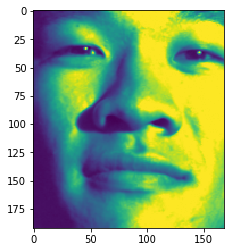

In [15]:
plt.imshow(A[...,0].reshape(im_size))

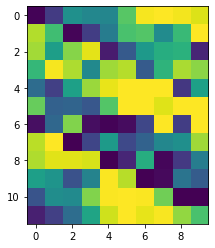

In [16]:
plt.imshow(A_ds_cv[...,0].reshape(ds_cv_shape))

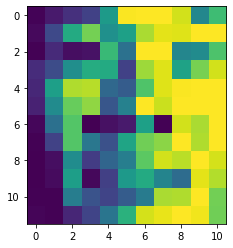

In [17]:
plt.imshow(A_ds[...,0].reshape(ds_shape))

In [18]:
A_wave.shape

(8064, 1207)

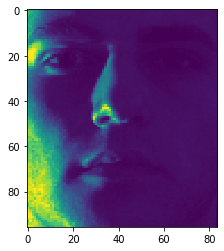

In [19]:
plt.imshow(A_wave[...,1].reshape(wave_shape))

In [20]:
A_pca, _ = down_samp_pca(A)

In [21]:
A_pca.shape

(132, 1207)

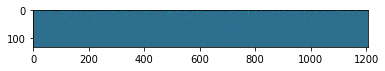

In [22]:
plt.imshow(A_pca)

In [23]:
# def delta(x, i):
#     assert i < num_class
#     out = np.zeros(len(x))
#     idxs = slice(i*num_class, i*num_class+num_train)
#     out[idxs] = x[idxs]
#     return out

In [24]:
def delta_i(x, i, gt):
    return np.where(gt==i, x, 0)

In [25]:
min(test_gt)

0

In [26]:
@ignore_warnings(category=ConvergenceWarning)
def identity(A, y, class_idxs):
    A_norm = np.linalg.norm(A, axis=0)
    y_norm = np.linalg.norm(y)
#     print(A, y)
    prob = Lasso(fit_intercept=False, alpha=1e-4, max_iter=1e3)
#     prob = LassoCV(fit_intercept=False, max_iter=1e4)
    prob.fit(A/A_norm, y/y_norm)
    x_hat = prob.coef_
    r = np.zeros(39)
    for i in range(39):
        r[i] = np.linalg.norm(y-A@delta_i(x_hat, i, class_idxs))
#     print(x_hat)
    return np.argmin(r)

In [27]:
np.linalg.norm(A, axis=0).shape

(1207,)

In [62]:
def evaluate(A, y, train_gt, test_gt, ld_func=down_samp, robust=False):
    train_pred = np.ones_like(train_gt)*-1
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A)
        y_ld, _ = ld_func(y)
    
#     print(A_ld.shape, y_ld.shape)
    for i in tqdm(range(len(train_pred))):
        if robust:
            train_pred[i] = robust_identity(A_ld, A_ld[:,i], train_gt)
        else:
            train_pred[i] = identity(A_ld, A_ld[:,i], train_gt)
#         print(train_pred[i], train_gt[i])
    
    for i in tqdm(range(len(test_pred))):
        if robust:
            test_pred[i] = robust_identity(A_ld, y_ld[:,i], train_gt)
        else:
            test_pred[i] = identity(A_ld, y_ld[:,i], train_gt)
    
#     print(train_pred)
    train_acc = accuracy_score(train_gt, train_pred)*100
    test_acc = accuracy_score(test_gt, test_pred)*100
    
    print("Accuracy for {}:\n\tTrain Accuracy: {:.2f}\n\tTest Accuracy: {:.2f}".format(ld_func.__name__, train_acc, test_acc))

In [30]:
down_samp_funcs = [down_samp, down_samp_wave,  down_samp_pca]

In [44]:
for func in down_samp_funcs:
    evaluate(A, y, train_gt, test_gt, ld_func=func)


  3%|▎         | 22/719 [00:04<02:31,  4.60it/s]

KeyboardInterrupt: 

In [31]:
# Corrupt data for robust identity
def corrupt(test_mat, percent=0.3):
    im_size, num_ims = test_mat.shape
    corrupt_mat = test_mat.copy()
    corrupt_size = int(im_size*percent)
    for i in range(num_ims):
        corrupt_idxs = np.random.choice(im_size, size=corrupt_size, replace=False)
        corrupt_data = np.random.randint(256, size=corrupt_size)
        corrupt_mat[:,i][corrupt_idxs] = corrupt_data
#     print(im_size, num_ims, corrupt_size)
    return corrupt_mat

In [51]:
y_ds, y_ds_sh = down_samp(y)
y_wave, y_wave_sh = down_samp_wave(y)

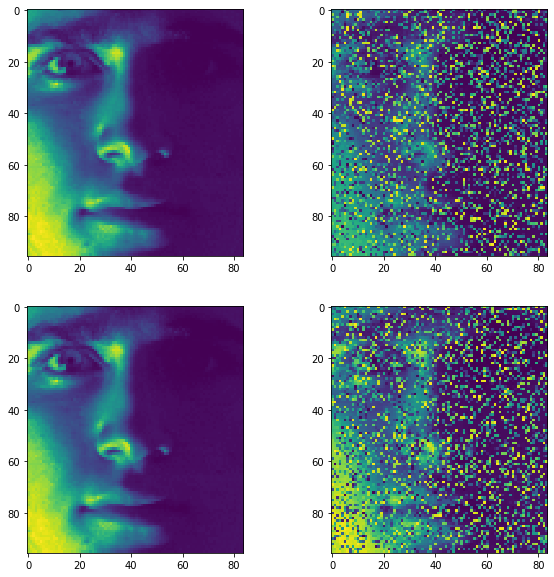

In [52]:
perc = 0.4
k = 1

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(y_ds[:,k].reshape(y_ds_sh))
plt.subplot(222)
plt.imshow(corrupt(y_ds, perc)[:,k].reshape(y_ds_sh))
plt.subplot(223)
plt.imshow(y_wave[:,k].reshape(y_wave_sh))
plt.subplot(224)
plt.imshow(corrupt(y_wave, perc)[:,k].reshape(y_wave_sh))
plt.show()

In [93]:
@ignore_warnings(category=ConvergenceWarning)
def robust_identity(A, B, y, class_idxs):
#     A_norm = np.linalg.norm(A, axis=0)
#     y_norm = np.linalg.norm(y)
    m,n = A.shape
#     B = np.hstack((A, np.eye(m)))
#     B_norm = np.linalg.norm(B, axis=0)
#     print(B.shape)
    prob = Lasso(fit_intercept=False, alpha=1e-10)
    prob.fit(B, y)
    w_hat = prob.coef_
    x_hat = w_hat[:n]
    e_hat = w_hat[n:]
    r = np.zeros(39)
    for i in range(39):
        r[i] = np.linalg.norm(y-e_hat-A@delta_i(x_hat, i, class_idxs))
    r_fixed = np.delete(r, 13)
    return np.argmin(r_fixed)

In [90]:
def evaluate_robust(A, y, train_gt, test_gt, ld_func=down_samp):
    
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A)
        y_ld, _ = ld_func(y)
    print(A_ld.shape, y_ld.shape)
#     corrupt_percs = np.arange(0,1,0.1)
#     corrupt_percs = [0, 0.4, 0.6]
    corrupt_percs = [0]
    test_acc = []
    
    m,n = A_ld.shape
    B = np.hstack((A_ld, np.eye(m)))
    B = B/np.linalg.norm(B, axis=0)
    print(B.shape)
    for perc in corrupt_percs:
        corrupt_y = corrupt(y_ld, perc)
        corrupt_y = corrupt_y/np.linalg.norm(corrupt_y, axis=0)
        for i in tqdm(range(len(test_pred)), position=0, leave=True):
            test_pred[i] = robust_identity(A_ld, B, corrupt_y[:,i],train_gt)

    #     print(train_pred)
        test_acc.append(accuracy_score(test_gt, test_pred)*100)
        print(test_acc[-1])
        
        print(test_pred, test_gt)
    
    print("Robust Identity Accuracy for {}:\n\tTest Accuracy: {}".format(ld_func.__name__, test_acc))
    return test_acc

In [91]:
# Robust data read
train_cond = lambda az, elev: abs(az) <= 25 and abs(elev) <= 25
test_cond = lambda az, elev: 25 <= abs(az) <= 100 and 25 <= abs(elev) <= 65
# train_cond = lambda az, elev: abs(elev) <= 25
# test_cond = lambda az, elev: 25 <= abs(elev)
A, y, train_gt, test_gt, names = random_sample_cond(train_cond, test_cond)
print(A.shape, y.shape)
# print(train_gt)
print(test_gt[10], names[1][10])

(32256, 719) (32256, 373)
33 CroppedYale/yaleB34/yaleB34_P00A-070E-35.pgm


In [92]:
#TODO: Change train and test data for robust
#TODO: Change ds factor for robust
down_samp_funcs = [down_samp, down_samp_wave]
test_accs = []
for func in down_samp_funcs:
    test_accs.append(evaluate_robust(A, A[...,11,None], train_gt, train_gt[...,11,None], ld_func=func))

(8064, 719) (8064, 1)


  0%|          | 0/1 [00:00<?, ?it/s]

(8064, 8783)


  0%|          | 0/1 [00:02<?, ?it/s]


IndexError: index 38 is out of bounds for axis 0 with size 38

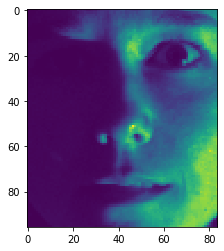

In [54]:
# plt.imshow(y[...,10].reshape(im_size))
plt.imshow(y_ds[...,10].reshape(y_ds_sh))